In [1]:
# library to handle data in a vectorized manner
import numpy as np 

# library for data analsysis
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json 

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# map rendering library
import folium 

#Math functions
from math import sqrt

# k-means from clustering stage
from sklearn.cluster import KMeans

# pearson correlation library
import scipy.stats

# data visualization library
import seaborn as sns

print('Libraries imported.')

Libraries imported.


# Data Collection

**Scrape Wikipedia to get the 88 cities within LA County and their populations**

In [35]:
url = "https://en.wikipedia.org/wiki/List_of_cities_in_Los_Angeles_County,_California"
df_read = pd.read_html(url)
df = df_read[0]

In [36]:
df.head()

,City,Date incorporated,Population as of(2010 Census)
0,Agoura Hills,"December 8, 1982",20330
1,Alhambra,"July 11, 1903",83653
2,Arcadia,"August 5, 1903",56364
3,Artesia,"May 29, 1959",16522
4,Avalon,"June 26, 1913",3728


**Scrape the LA County Public Health website to get the number of COVID-19 cases per city**

In [32]:
url_covid = "http://publichealth.lacounty.gov/media/coronavirus/locations.htm"
df_read = pd.read_html(url_covid)
df_covid = df_read[1]

In [33]:
df_covid.head()

,CITY/COMMUNITY**,Cases,Case Rate1,Deaths,Death Rate2
0,City of Agoura Hills,712,3409.0,11,53.0
1,City of Alhambra,5153,5942.0,88,101.0
2,City of Arcadia,2010,3480.0,64,111.0
3,City of Artesia,1569,9342.0,31,185.0
4,City of Avalon,6,155.0,0,0.0


# Data Preparation

In [37]:
# drop the 'Date incorporated' column
df = df.drop('Date incorporated', 1)

# rename population
df.rename(columns={'Population as of(2010 Census)':'Population'}, inplace=True)

In [39]:
# update this value
df.loc[38,'City'] = "La Canada Flintridge"

In [40]:
df.head()

,City,Population
0,Agoura Hills,20330
1,Alhambra,83653
2,Arcadia,56364
3,Artesia,16522
4,Avalon,3728


In [41]:
# drop columns that we don't need
df_covid = df_covid.drop('Case Rate1',1).drop('Deaths',1).drop('Death Rate2',1)

# rename df_covid city
df_covid.rename(columns={'CITY/COMMUNITY**':'City'}, inplace=True)

In [42]:
df_covid.head()

,City,Cases
0,City of Agoura Hills,712
1,City of Alhambra,5153
2,City of Arcadia,2010
3,City of Artesia,1569
4,City of Avalon,6


In [43]:
df.shape

(88, 2)

In [44]:
df_covid.shape

(342, 2)

In [45]:
df_covid['City'].unique()

array(['City of Agoura Hills', 'City of Alhambra', 'City of Arcadia',
       'City of Artesia', 'City of Avalon', 'City of Azusa',
       'City of Baldwin Park', 'City of Bell', 'City of Bell Gardens',
       'City of Bellflower', 'City of Beverly Hills', 'City of Bradbury',
       'City of Burbank', 'City of Calabasas', 'City of Carson',
       'City of Cerritos', 'City of Claremont', 'City of Commerce*',
       'City of Compton', 'City of Covina', 'City of Cudahy',
       'City of Culver City', 'City of Diamond Bar', 'City of Downey',
       'City of Duarte', 'City of El Monte', 'City of El Segundo',
       'City of Gardena', 'City of Glendale', 'City of Glendora',
       'City of Hawaiian Gardens', 'City of Hawthorne',
       'City of Hermosa Beach', 'City of Hidden Hills',
       'City of Huntington Park', 'City of Industry', 'City of Inglewood',
       'City of Irwindale', 'City of La Canada Flintridge',
       'City of La Habra Heights', 'City of La Mirada',
       'City of La Pu

**Remove rows that are not needed**

In [46]:
df_covid = df_covid[~df_covid['City'].astype(str).str.startswith('Unincorporated')]
df_covid = df_covid[~df_covid['City'].astype(str).str.startswith('Los Angeles')]
df_covid = df_covid[~df_covid['City'].astype(str).str.startswith('- Under')]

In [47]:
df_covid.shape

(85, 2)

**Remove the first 8 characters of each row in City column**

In [48]:
df_covid['City'] = df_covid['City'].str[8:]

In [49]:
df_covid['City'].unique()

array(['Agoura Hills', 'Alhambra', 'Arcadia', 'Artesia', 'Avalon',
       'Azusa', 'Baldwin Park', 'Bell', 'Bell Gardens', 'Bellflower',
       'Beverly Hills', 'Bradbury', 'Burbank', 'Calabasas', 'Carson',
       'Cerritos', 'Claremont', 'Commerce*', 'Compton', 'Covina',
       'Cudahy', 'Culver City', 'Diamond Bar', 'Downey', 'Duarte',
       'El Monte', 'El Segundo', 'Gardena', 'Glendale', 'Glendora',
       'Hawaiian Gardens', 'Hawthorne', 'Hermosa Beach', 'Hidden Hills',
       'Huntington Park', 'Industry', 'Inglewood', 'Irwindale',
       'La Canada Flintridge', 'La Habra Heights', 'La Mirada',
       'La Puente', 'La Verne', 'Lakewood', 'Lancaster*', 'Lawndale',
       'Lomita', 'Lynwood*', 'Malibu', 'Manhattan Beach', 'Maywood',
       'Monrovia', 'Montebello', 'Monterey Park', 'Norwalk', 'Palmdale',
       'Palos Verdes Estates', 'Paramount', 'Pico Rivera', 'Pomona',
       'Rancho Palos Verdes', 'Redondo Beach', 'Rolling Hills',
       'Rolling Hills Estates', 'Rosemead', 'S

**Update the four rows that have an asterisk**

In [50]:
df_covid.loc[17,'City'] = "Commerce"
df_covid.loc[44,'City'] = "Lancaster"
df_covid.loc[47,'City'] = 'Lynwood'
df_covid.loc[65,'City'] = 'San Dimas'

In [51]:
df_covid.head(20)

,City,Cases
0,Agoura Hills,712
1,Alhambra,5153
2,Arcadia,2010
3,Artesia,1569
4,Avalon,6
5,Azusa,4928
6,Baldwin Park,10332
7,Bell,5270
8,Bell Gardens,6657
9,Bellflower,8323


**Merge the two dataframes based on the City**

In [52]:
df = df.merge(df_covid, on='City', how='left')

In [53]:
df

,City,Population,Cases
0,Agoura Hills,20330,712.0
1,Alhambra,83653,5153.0
2,Arcadia,56364,2010.0
3,Artesia,16522,1569.0
4,Avalon,3728,6.0
5,Azusa,46361,4928.0
6,Baldwin Park,75390,10332.0
7,Bell,35477,5270.0
8,Bell Gardens,42072,6657.0
9,Bellflower,76616,8323.0


**Long Beach, Los Angeles, and Pasadena did not have any case amounts. Therefore, I will remove them to ensure we have no NaN values**

In [54]:
df = df[df['Cases'].notna()]

In [55]:
df.shape

(85, 3)

**Get the cases per population for each city**

In [56]:
for index, row in df.iterrows():
    df.loc[df['City'] == row['City'], 'C/P'] = (row['Cases'] / row['Population'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [57]:
df.head()

,City,Population,Cases,C/P
0,Agoura Hills,20330,712.0,0.035022
1,Alhambra,83653,5153.0,0.061600
2,Arcadia,56364,2010.0,0.035661
3,Artesia,16522,1569.0,0.094964
4,Avalon,3728,6.0,0.001609


In [58]:
df.reset_index(drop=True, inplace=True)

In [59]:
df.shape

(85, 4)

**Add a 'CA' at the end of each city to get more accurate Foursquare search results**

In [60]:
df['City'] = df['City'].astype(str) + ", CA"

<ipython-input-60-a886bebab4a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['City'] = df['City'].astype(str) + ", CA"


In [61]:
df.head()

,City,Population,Cases,C/P
0,"Agoura Hills, CA",20330,712.0,0.035022
1,"Alhambra, CA",83653,5153.0,0.061600
2,"Arcadia, CA",56364,2010.0,0.035661
3,"Artesia, CA",16522,1569.0,0.094964
4,"Avalon, CA",3728,6.0,0.001609


# Foursquare API

**Create functions**

In [62]:
# function to return latitude and longitude with inputted city address
def getCoordinates(city):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

# function to call Foresquare API and return list of 'Shops & Services'
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            150,
            '4d4b7105d754a06378d81259')
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**For each city in our dataframe, use geopy to get its latitude and longitude**

In [64]:
for item in df['City']:    
    coordinates = getCoordinates(item)
    df.loc[df['City'] == item, 'Latitude'] = coordinates[0]
    df.loc[df['City'] == item, 'Longitude'] = coordinates[1]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [65]:
df.head()

,City,Population,Cases,C/P,Latitude,Longitude
0,"Agoura Hills, CA",20330,712.0,0.035022,34.147910,-118.765704
1,"Alhambra, CA",83653,5153.0,0.061600,34.093042,-118.127060
2,"Arcadia, CA",56364,2010.0,0.035661,34.136207,-118.040150
3,"Artesia, CA",16522,1569.0,0.094964,33.869020,-118.079620
4,"Avalon, CA",3728,6.0,0.001609,33.342210,-118.327261


**Display all 85 of our cities on a Folium map**

In [67]:
los_angeles = getCoordinates('Los Angeles, CA')
latitude = los_angeles[0]
longitude = los_angeles[1]

# create map of Manhattan using latitude and longitude values
map_of_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_of_LA)  
    
map_of_LA

In [68]:
df_venues = getNearbyVenues(names=df['City'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Agoura Hills, CA
Alhambra, CA
Arcadia, CA
Artesia, CA
Avalon, CA
Azusa, CA
Baldwin Park, CA
Bell, CA
Bell Gardens, CA
Bellflower, CA
Beverly Hills, CA
Bradbury, CA
Burbank, CA
Calabasas, CA
Carson, CA
Cerritos, CA
Claremont, CA
Commerce, CA
Compton, CA
Covina, CA
Cudahy, CA
Culver City, CA
Diamond Bar, CA
Downey, CA
Duarte, CA
El Monte, CA
El Segundo, CA
Gardena, CA
Glendale, CA
Glendora, CA
Hawaiian Gardens, CA
Hawthorne, CA
Hermosa Beach, CA
Hidden Hills, CA
Huntington Park, CA
Industry, CA
Inglewood, CA
Irwindale, CA
La Canada Flintridge, CA
La Habra Heights, CA
La Mirada, CA
La Puente, CA
La Verne, CA
Lakewood, CA
Lancaster, CA
Lawndale, CA
Lomita, CA
Lynwood, CA
Malibu, CA
Manhattan Beach, CA
Maywood, CA
Monrovia, CA
Montebello, CA
Monterey Park, CA
Norwalk, CA
Palmdale, CA
Palos Verdes Estates, CA
Paramount, CA
Pico Rivera, CA
Pomona, CA
Rancho Palos Verdes, CA
Redondo Beach, CA
Rolling Hills, CA
Rolling Hills Estates, CA
Rosemead, CA
San Dimas, CA
San Fernando, CA
San Gabriel, C

In [69]:
df_venues.shape

(2995, 7)

In [71]:
df_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Agoura Hills, CA",34.14791,-118.765704,Kramer's Pharmacy,34.148146,-118.767356,Pharmacy
1,"Agoura Hills, CA",34.14791,-118.765704,Patagonia Building Supplies,34.145882,-118.765800,Construction & Landscaping
2,"Agoura Hills, CA",34.14791,-118.765704,grhgrhg,34.145882,-118.765800,Furniture / Home Store
3,"Agoura Hills, CA",34.14791,-118.765704,Solid Appliance Repair Service,34.149849,-118.762772,Home Service
4,"Agoura Hills, CA",34.14791,-118.765704,"SAIG Insurance Solutions, Inc",34.144680,-118.765633,Insurance Office


In [72]:
df_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
"Agoura Hills, CA",13,13,13,13,13,13
"Alhambra, CA",72,72,72,72,72,72
"Arcadia, CA",8,8,8,8,8,8
"Artesia, CA",40,40,40,40,40,40
"Avalon, CA",50,50,50,50,50,50
"Azusa, CA",45,45,45,45,45,45
"Baldwin Park, CA",65,65,65,65,65,65
"Bell Gardens, CA",12,12,12,12,12,12
"Bell, CA",31,31,31,31,31,31


In [73]:
df_merge = df_venues.groupby('City').count()

In [74]:
df_merge.head()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
"Agoura Hills, CA",13,13,13,13,13,13
"Alhambra, CA",72,72,72,72,72,72
"Arcadia, CA",8,8,8,8,8,8
"Artesia, CA",40,40,40,40,40,40
"Avalon, CA",50,50,50,50,50,50


In [75]:
df_merge = df_merge.reset_index()

In [77]:
df_merge = df_merge.drop('City Latitude',1).drop('City Longitude',1).drop('Venue Latitude',1).drop('Venue Longitude',1).drop('Venue Category',1)

In [78]:
df_merge.shape

(84, 2)

In [79]:
df_merge.head()

,City,Venue
0,"Agoura Hills, CA",13
1,"Alhambra, CA",72
2,"Arcadia, CA",8
3,"Artesia, CA",40
4,"Avalon, CA",50


**Now merge the total venues with the main dataframe**

In [81]:
df = df.merge(df_merge, on='City', how='left')

In [82]:
df.head()

,City,Population,Cases,C/P,Latitude,Longitude,Venue
0,"Agoura Hills, CA",20330,712.0,0.035022,34.147910,-118.765704,13.0
1,"Alhambra, CA",83653,5153.0,0.061600,34.093042,-118.127060,72.0
2,"Arcadia, CA",56364,2010.0,0.035661,34.136207,-118.040150,8.0
3,"Artesia, CA",16522,1569.0,0.094964,33.869020,-118.079620,40.0
4,"Avalon, CA",3728,6.0,0.001609,33.342210,-118.327261,50.0


In [83]:
df.shape

(85, 7)

**Delete Palos Verdes Estates, CA as it did not come up with any venues**

In [85]:
df = df[df['Venue'].notna()]

In [86]:
df.shape

(84, 7)

# Clustering the cities

In [88]:
df_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Agoura Hills, CA",34.14791,-118.765704,Kramer's Pharmacy,34.148146,-118.767356,Pharmacy
1,"Agoura Hills, CA",34.14791,-118.765704,Patagonia Building Supplies,34.145882,-118.765800,Construction & Landscaping
2,"Agoura Hills, CA",34.14791,-118.765704,grhgrhg,34.145882,-118.765800,Furniture / Home Store
3,"Agoura Hills, CA",34.14791,-118.765704,Solid Appliance Repair Service,34.149849,-118.762772,Home Service
4,"Agoura Hills, CA",34.14791,-118.765704,"SAIG Insurance Solutions, Inc",34.144680,-118.765633,Insurance Office


**One hot encoding**

In [89]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
df_onehot['City'] = df_venues['City'] 

# move city column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,City,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dive Shop,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store,Flea Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Hobby Shop,Home Service,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Knitting Store,Laundromat,Lawyer,Lighting Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pop-Up Shop,Print Shop,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Souvenir Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Used Bookstore,Vape Store,Video Game Store,Video Store,Warehouse Store,Watch Shop,Wine Shop,Women's Store
0,"Agoura Hills, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Agoura Hills, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Agoura Hills, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Agoura Hills, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Agoura Hills, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
df_onehot.shape

(2995, 116)

In [91]:
df_grouped = df_onehot.groupby('City').mean().reset_index()
df_grouped

,City,ATM,Accessories Store,Antique Shop,Arts & Crafts Store,Astrologer,Auto Garage,Auto Workshop,Baby Store,Big Box Store,Board Shop,Bookstore,Boutique,Bridal Shop,Business Service,Camera Store,Candy Store,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Department Store,Discount Store,Dive Shop,Dry Cleaner,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store,Flea Market,Flower Shop,Food & Drink Shop,Food Service,Frame Store,Furniture / Home Store,Garden Center,Gift Shop,Gourmet Shop,Grocery Store,Gun Shop,Health & Beauty Service,Health Food Store,Hobby Shop,Home Service,IT Services,Insurance Office,Jewelry Store,Kids Store,Kitchen Supply Store,Knitting Store,Laundromat,Lawyer,Lighting Store,Liquor Store,Locksmith,Marijuana Dispensary,Market,Massage Studio,Mattress Store,Medical Supply Store,Men's Store,Mobile Phone Shop,Motorcycle Shop,Motorsports Shop,Music Store,Notary,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Pawn Shop,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pop-Up Shop,Print Shop,Record Shop,Recording Studio,Rental Service,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Souvenir Shop,Sporting Goods Shop,Stationery Store,Supermarket,Supplement Shop,Tailor Shop,Thrift / Vintage Store,Toy / Game Store,Used Bookstore,Vape Store,Video Game Store,Video Store,Warehouse Store,Watch Shop,Wine Shop,Women's Store
0,"Agoura Hills, CA",0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230769,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alhambra, CA",0.000000,0.013889,0.000000,0.027778,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.013889,0.027778,0.00000,0.041667,0.000000,0.013889,0.013889,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.027778,0.041667,0.000000,0.013889,0.027778,0.00,0.000000,0.027778,0.000000,0.000000,0.000000,0.013889,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013889,0.000000,0.041667,0.000000,0.000000,0.138889,0.013889,0.027778,0.013889,0.000000,0.000000,0.000000,0.000000,0.069444,0.000000,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.013889,0.000000,0.000000,0.000000,0.013889,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.013889,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.041667,0.000000,0.013889,0.013889,0.013889,0.000000,0.00,0.013889,0.013889,0.000000,0.000000,0.013889,0.013889,0.027778,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778
2,"Arcadia, CA",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000

**Print top 5 venues for each city**

In [92]:
num_top_venues = 5

for hood in df_grouped['City']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agoura Hills, CA----
                        venue  freq
0                Home Service  0.23
1  Construction & Landscaping  0.15
2                         ATM  0.08
3            Toy / Game Store  0.08
4                    Pharmacy  0.08


----Alhambra, CA----
                     venue  freq
0             Home Service  0.14
1                   Lawyer  0.07
2  Health & Beauty Service  0.04
3               Shoe Store  0.04
4           Cosmetics Shop  0.04


----Arcadia, CA----
               venue  freq
0   Business Service  0.25
1       Home Service  0.12
2        Pop-Up Shop  0.12
3  Other Repair Shop  0.12
4     Clothing Store  0.12


----Artesia, CA----
              venue  freq
0      Home Service  0.25
1          Boutique  0.10
2          Pharmacy  0.08
3    Cosmetics Shop  0.08
4  Business Service  0.08


----Avalon, CA----
              venue  freq
0         Gift Shop  0.22
1    Clothing Store  0.12
2          Boutique  0.08
3     Grocery Store  0.06
4  Business Service  0.06

              venue  freq
0  Business Service   0.6
1    Massage Studio   0.2
2      Home Service   0.2
3               ATM   0.0
4            Notary   0.0


----Norwalk, CA----
              venue  freq
0      Home Service  0.16
1  Insurance Office  0.11
2            Lawyer  0.11
3        Shoe Store  0.11
4  Department Store  0.11


----Palmdale, CA----
               venue  freq
0   Business Service  0.28
1   Insurance Office  0.17
2       Home Service  0.13
3  Other Repair Shop  0.06
4             Lawyer  0.06


----Paramount, CA----
              venue  freq
0      Home Service   0.2
1    Clothing Store   0.2
2  Business Service   0.2
3            Lawyer   0.1
4    Cosmetics Shop   0.1


----Pico Rivera, CA----
               venue  freq
0       Home Service  0.17
1  Mobile Phone Shop  0.10
2      Women's Store  0.06
3     Cosmetics Shop  0.06
4     Clothing Store  0.06


----Pomona, CA----
              venue  freq
0            Lawyer  0.16
1      Home Service  0.15
2  Business Se

In [93]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Create dataframe with top 10 venues for each city**

In [94]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = df_grouped['City']

for ind in np.arange(df_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Agoura Hills, CA",Home Service,Construction & Landscaping,Knitting Store,Pharmacy,Furniture / Home Store,Insurance Office,Liquor Store,Medical Supply Store,ATM,Toy / Game Store
1,"Alhambra, CA",Home Service,Lawyer,Health & Beauty Service,Business Service,Shoe Store,Cosmetics Shop,Women's Store,Electronics Store,Clothing Store,Convenience Store
2,"Arcadia, CA",Business Service,Other Repair Shop,IT Services,Home Service,Pop-Up Shop,Optical Shop,Clothing Store,Women's Store,Flea Market,Fireworks Store
3,"Artesia, CA",Home Service,Boutique,Pharmacy,Cosmetics Shop,Business Service,Lawyer,Insurance Office,Food & Drink Shop,Mobile Phone Shop,Baby Store
4,"Avalon, CA",Gift Shop,Clothing Store,Boutique,Business Service,Grocery Store,Candy Store,Sporting Goods Shop,ATM,Massage Studio,Outdoor Supply Store


**Clustering**

In [95]:
# set number of clusters
kclusters = 5

df_grouped_clustering = df_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 0, 2, 2, 2, 2, 2, 4], dtype=int32)

In [96]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = df

cities_merged = cities_merged.join(cities_venues_sorted.set_index('City'), on='City')

cities_merged.head() # check the last columns!

,City,Population,Cases,C/P,Latitude,Longitude,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Agoura Hills, CA",20330,712.0,0.035022,34.147910,-118.765704,13.0,0,Home Service,Construction & Landscaping,Knitting Store,Pharmacy,Furniture / Home Store,Insurance Office,Liquor Store,Medical Supply Store,ATM,Toy / Game Store
1,"Alhambra, CA",83653,5153.0,0.061600,34.093042,-118.127060,72.0,2,Home Service,Lawyer,Health & Beauty Service,Business Service,Shoe Store,Cosmetics Shop,Women's Store,Electronics Store,Clothing Store,Convenience Store
2,"Arcadia, CA",56364,2010.0,0.035661,34.136207,-118.040150,8.0,2,Business Service,Other Repair Shop,IT Services,Home Service,Pop-Up Shop,Optical Shop,Clothing Store,Women's Store,Flea Market,Fireworks Store
3,"Artesia, CA",16522,1569.0,0.094964,33.869020,-118.079620,40.0,0,Home Service,Boutique,Pharmacy,Cosmetics Shop,Business Service,Lawyer,Insurance Office,Food & Drink Shop,Mobile Phone Shop,Baby Store
4,"Avalon, CA",3728,6.0,0.001609,33.342210,-118.327261,50.0,2,Gift Shop,Clothing Store,Boutique,Business Service,Grocery Store,Candy Store,Sporting Goods Shop,ATM,Massage Studio,Outdoor Supply Store


**Cluster 1**

In [97]:
cluster_one = cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[0] + list(range(1, cities_merged.shape[1]))]]
cluster_one

,City,Population,Cases,C/P,Latitude,Longitude,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Agoura Hills, CA",20330,712.0,0.035022,34.147910,-118.765704,13.0,0,Home Service,Construction & Landscaping,Knitting Store,Pharmacy,Furniture / Home Store,Insurance Office,Liquor Store,Medical Supply Store,ATM,Toy / Game Store
3,"Artesia, CA",16522,1569.0,0.094964,33.869020,-118.079620,40.0,0,Home Service,Boutique,Pharmacy,Cosmetics Shop,Business Service,Lawyer,Insurance Office,Food & Drink Shop,Mobile Phone Shop,Baby Store
13,"Calabasas, CA",23058,843.0,0.036560,34.144664,-118.644097,2.0,0,Home Service,Construction & Landscaping,Women's Store,Frame Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio
15,"Cerritos, CA",49041,2178.0,0.044412,33.864429,-118.053932,7.0,0,Business Service,Furniture / Home Store,Home Service,Accessories Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store
20,"Cudahy, CA",23805,3770.0,0.158370,33.962058,-118.183539,19.0,0,Home Service,Construction & Landscaping,Lawyer,Mobile Phone Shop,Market,Clothing Store,Business Service,Convenience Store,Cosmetics Shop,Gun Shop
22,"Diamond Bar, CA",55544,2390.0,0.043029,34.028623,-117.810337,35.0,0,Home Service,Business Service,Lawyer,Construction & Landscaping,Convenience Store,Other Repair Shop,Insurance Office,Video Game Store,Liquor Store,Print Shop
29,"Glendora, CA",50073,3633.0,0.072554,34.136119,-117.865339,77.0,0,Home Service,Business Service,Lawyer,Jewelry Store,Insurance Office,Arts & Crafts Store,Bookstore,Other Repair Shop,Medical Supply Store,Construction & Landscaping
41,"La Puente, CA",39816,5319.0,0.133590,34.019790,-117.950368,37.0,0,Home Service,Construction & Landscaping,Business Service,Lawyer,Other Repair Shop,Shop & Service,Women's Store,Flower Shop,Optical Shop,Paper / Office Supplies Store
42,"La Verne, CA",31063,2126.0,0.068442,34.100843,-117.767836,25.0,0,Home Service,Business Service,Insurance Office,Lawyer,Liquor Store,Flea Market,Farmers Market,Electronics Store,Jewelry Store,Convenience Store
44,"Lancaster, CA",160316,16516.0,0.103022,34.698106,-118.136615,44.0,0,Home Service,Business Service,Construction & Landscaping,Lawyer,Furniture / Home Store,Jewelry Store,Mobile Phone Shop,Insurance Office,Other Repair Shop,Farmers Market


**Cluster 2**

In [98]:
cluster_two = cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[0] + list(range(1, cities_merged.shape[1]))]]
cluster_two

,City,Population,Cases,C/P,Latitude,Longitude,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,"Monterey Park, CA",60269,3598.0,0.059699,34.051522,-118.129807,5.0,1,Business Service,Home Service,Massage Studio,Furniture / Home Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store
62,"Rolling Hills, CA",1860,32.0,0.017204,33.766804,-118.349662,2.0,1,Business Service,Furniture / Home Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store,Flea Market
63,"Rolling Hills Estates, CA",8067,177.0,0.021941,33.787794,-118.358128,1.0,1,Business Service,Furniture / Home Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store,Flea Market


**Cluster 3**

In [99]:
cluster_three = cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[0] + list(range(1, cities_merged.shape[1]))]]
cluster_three

,City,Population,Cases,C/P,Latitude,Longitude,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Alhambra, CA",83653,5153.0,0.061600,34.093042,-118.127060,72.0,2,Home Service,Lawyer,Health & Beauty Service,Business Service,Shoe Store,Cosmetics Shop,Women's Store,Electronics Store,Clothing Store,Convenience Store
2,"Arcadia, CA",56364,2010.0,0.035661,34.136207,-118.040150,8.0,2,Business Service,Other Repair Shop,IT Services,Home Service,Pop-Up Shop,Optical Shop,Clothing Store,Women's Store,Flea Market,Fireworks Store
4,"Avalon, CA",3728,6.0,0.001609,33.342210,-118.327261,50.0,2,Gift Shop,Clothing Store,Boutique,Business Service,Grocery Store,Candy Store,Sporting Goods Shop,ATM,Massage Studio,Outdoor Supply Store
5,"Azusa, CA",46361,4928.0,0.106296,34.133875,-117.905605,45.0,2,Business Service,Home Service,Insurance Office,Lawyer,Mobile Phone Shop,Pharmacy,Big Box Store,Sporting Goods Shop,ATM,Farmers Market
6,"Baldwin Park, CA",75390,10332.0,0.137047,34.085474,-117.961176,65.0,2,Home Service,Business Service,Insurance Office,Mobile Phone Shop,Pharmacy,Discount Store,Pawn Shop,Grocery Store,Other Repair Shop,Smoke Shop
7,"Bell, CA",35477,5270.0,0.148547,33.974781,-118.186636,31.0,2,Home Service,Mobile Phone Shop,Sporting Goods Shop,Convenience Store,Business Service,Pet Store,Locksmith,Print Shop,Flea Market,Shipping Store
8,"Bell Gardens, CA",42072,6657.0,0.158229,33.969456,-118.150395,12.0,2,Business Service,Locksmith,Convenience Store,Mobile Phone Shop,Men's Store,Sporting Goods Shop,Photography Studio,Home Service,Lawyer,Health & Beauty Service
10,"Beverly Hills, CA",34109,1941.0,0.056906,34.069650,-118.396306,100.0,2,Lawyer,Health & Beauty Service,Jewelry Store,Clothing Store,Furniture / Home Store,Business Service,Cosmetics Shop,Home Service,Boutique,Men's Store
12,"Burbank, CA",103340,6301.0,0.060973,34.181648,-118.325855,48.0,2,Construction & Landscaping,Home Service,Business Service,Insurance Office,Pharmacy,Print Shop,Locksmith,Sporting Goods Shop,Optical Shop,Convenience Store
14,"Carson, CA",91714,6721.0,0.073282,33.832204,-118.251755,3.0,2,Business Service,Liquor Store,Massage Studio,Furniture / Home Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store


**Cluster 4**

In [100]:
cluster_four = cities_merged.loc[cities_merged['Cluster Labels'] == 3, cities_merged.columns[[0] + list(range(1, cities_merged.shape[1]))]]
cluster_four

,City,Population,Cases,C/P,Latitude,Longitude,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,"Rancho Palos Verdes, CA",41643,950.0,0.022813,33.748331,-118.370768,2.0,3,Sporting Goods Shop,Furniture / Home Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store,Flea Market


**Cluster 5**

In [101]:
cluster_five = cities_merged.loc[cities_merged['Cluster Labels'] == 4, cities_merged.columns[[0] + list(range(1, cities_merged.shape[1]))]]
cluster_five

,City,Population,Cases,C/P,Latitude,Longitude,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Bellflower, CA",76616,8323.0,0.108633,33.882570,-118.116768,18.0,4,Home Service,Insurance Office,Lawyer,Shipping Store,Auto Garage,Convenience Store,Women's Store,Flower Shop,Flea Market,Fireworks Store
11,"Bradbury, CA",1048,32.0,0.030534,34.146951,-117.970898,3.0,4,Home Service,Business Service,Furniture / Home Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store
33,"Hidden Hills, CA",1856,53.0,0.028556,34.164091,-118.657837,1.0,4,Home Service,Women's Store,Frame Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store
39,"La Habra Heights, CA",5325,89.0,0.016714,33.960455,-117.950425,1.0,4,Home Service,Women's Store,Frame Store,Electronics Store,Entertainment Service,Event Service,Fabric Shop,Farmers Market,Film Studio,Fireworks Store


# Data Evaluation and Visualization

In [103]:
scipy.stats.pearsonr(df['C/P'], df['Venue'])

(-0.14341545141331907, 0.19309814049595883)

In [105]:
scipy.stats.pearsonr(cluster_three['C/P'], cluster_three['Venue'])

(-0.2774049180846046, 0.0384613561554066)

In [106]:
scipy.stats.pearsonr(cluster_one['C/P'], cluster_one['Venue'])

(-0.06938586665021455, 0.7713013929784998)

In [107]:
scipy.stats.pearsonr(cluster_two['C/P'], cluster_two['Venue'])

(0.9412630002233248, 0.21928050992118042)

In [109]:
scipy.stats.pearsonr(cluster_five['C/P'], cluster_five['Venue'])

(0.9930612439401423, 0.00693875605985772)

**Map the clusters**

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Text(0, 0.5, 'Number of public venues')

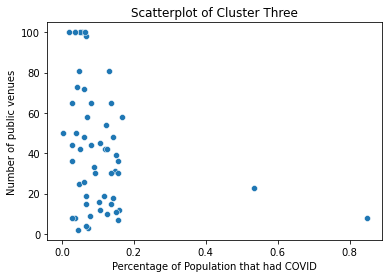

In [113]:
ax = sns.scatterplot(x='C/P', y='Venue',data=cluster_three)
ax.set_title("Scatterplot of Cluster Three")
ax.set_xlabel("Percentage of Population that had COVID")
ax.set_ylabel("Number of public venues")

Text(0, 0.5, 'Number of public venues')

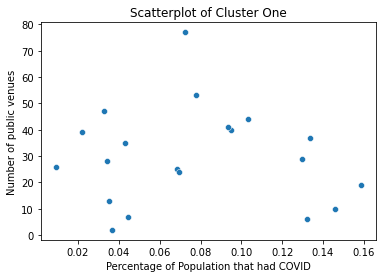

In [114]:
ax = sns.scatterplot(x='C/P', y='Venue',data=cluster_one)
ax.set_title("Scatterplot of Cluster One")
ax.set_xlabel("Percentage of Population that had COVID")
ax.set_ylabel("Number of public venues")